# Exploring the reference database
Let's see what properties we can find :) <br>
Let's put more data into it !

## TODOs
 - scale frequency spectrum before
 - species level precision (instead of strand level)
 - automate all : 
  - PCA/LDA/Autoencoder/nothing
  - number of bacteria and samples
 - treat plasmids differently
 - try with real Nanopore reads
 - unsupervised learning on all windows into 10 bins ?
 - hierarchical clustering ??
 - clustering with minimal distance
 - taxo id to family or genus
 - tsne plot
 - Add **Visualisation** : https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html
 - Save each case, not each run. don't run cases that have already been computed.

## Structure
In `genome/`, there's multiple sub-folder, we will start with `Bacteria`
It then contains all recorded species/strands in individual folders


http://defindit.com/readme_files/ncbi_file_extension_format.html

What we need is the taxo id, name, and the DNA, which can be found in:
 - .gbk for the taxo and name
 - .fna for the sequence

## Coding
## Import and Paths

In [1]:
import os
import pandas as pd
import numpy as np
import pickle
import traceback
import multiprocessing
import random
from datetime import datetime as dt
from time import time
from collections import Counter
from tqdm import tqdm_notebook as tqdm

In [2]:
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import umap

In [4]:
from sklearn.cluster import KMeans, MiniBatchKMeans

In [5]:
from sklearn import linear_model
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import ElasticNet
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [6]:
n_jobs = multiprocessing.cpu_count()

In [7]:
seed = 47
random.seed(seed)

In [8]:
plt.rcParams['figure.figsize'] = 13, 8

In [9]:
pd.options.display.float_format = '{:,.3f}'.format

In [10]:
path_ref_db = "/home/ubuntu/Data/NCBI/Bacteria_2015/"
path_kmer_freq = "/home/ubuntu/Data/kmer_freq/"

In [11]:
path_4mer = "4mer/V4/"
path_4mer = os.path.join(path_kmer_freq, path_4mer)

In [12]:
path_all = os.path.join("/home/ubuntu/TMP/", "_all_bacteria_4mers_float32.largepd")

In [11]:
path_all = os.path.join(path_4mer, "_all_bacteria_4mers_float.largepd")

In [ ]:
path_all = os.path.join(path_4mer, "_all_bacteria_4mers.largepd")

In [13]:
path_all

'/home/ubuntu/TMP/_all_bacteria_4mers_float32.largepd'

In [14]:
print(f"Found file: {os.path.isfile(path_all)}")

Found file: True


## Main dataset

Load the whole dataset. Will take a while !!

In [15]:
all_df = pd.read_pickle(path_all)

In [16]:
cols_kmers = all_df.columns.to_list()[4:-1]

In [17]:
cols_spe = sorted(list(set(all_df.columns.to_list()).difference(set(cols_kmers))))

In [18]:
unique_bacteria = len(all_df.bacteria.unique())
unique_bacteria

2782

In [19]:
all_df.shape

(953798, 261)

In [ ]:
scaler = MaxAbsScaler()
tmp_data = all_df[cols_kmers].T
scaler.fit_transform(tmp_data)
all_df[cols_kmers] = tmp_data.T

In [22]:
start = time()
all_df[cols_kmers] = all_df[cols_kmers].div(all_df[cols_kmers].max(axis=1), axis=0)
print(f"took {time() - start:.2f} s")

took 5.91 s


In [24]:
# scale by length (divide by 10k at the moment)
start = time()
for col in cols_kmers:
    all_df[col] /= 10000
print(f"took {time() - start:.2f} s")

took 0.56 s


In [20]:
# scale by max count
start = time()
maxs = all_df[cols_kmers].max(axis=1)
maxs[maxs==0] = 1  # Avoid div 0
for col in cols_kmers:
    all_df[col] /= maxs
print(f"took {time() - start:.2f} s")

took 4.63 s


In [21]:
# Or should scale by number of bases ?? so divded by length, could mult by 256 for easier reading

In [24]:
all_df.head(5)[cols_kmers]*10000

,AAAA,AAAC,AAAG,AAAT,AACA,AACC,AACG,AACT,AAGA,AAGC,...,TTCG,TTCT,TTGA,TTGC,TTGG,TTGT,TTTA,TTTC,TTTG,TTTT
0,20.000,24.000,19.000,26.000,15.000,43.000,31.000,25.000,36.000,33.000,...,38.000,25.000,47.000,52.000,40.000,26.000,6.000,28.000,29.000,28.000
1,16.000,16.000,23.000,14.000,22.000,28.000,31.000,27.000,40.000,27.000,...,45.000,17.000,41.000,35.000,40.000,18.000,11.000,24.000,17.000,9.000
2,18.000,21.000,26.000,16.000,26.000,23.000,36.000,22.000,34.000,31.000,...,53.000,43.000,44.000,50.000,58.000,52.000,14.000,46.000,43.000,37.000
3,5.000,12.000,15.000,12.000,5.000,29.000,30.000,24.000,19.000,19.000,...,42.000,21.000,36.000,31.000,59.000,36.000,6.000,27.000,38.000,25.000
4,13.000,24.000,18.000,17.000,21.000,30.000,27.000,24.000,18.000,31.000,...,28.000,22.000,29.000,49.000,50.000,35.000,7.000,14.000,14.000,6.000


## Reduction possibilities

In [14]:
components = 20
cols_reduc = [f"component_{i+1}" for i in range(components)]
cols_lda = [f"lda_{i+1}" for i in range(components)]

### PCA Principal Component Analysis
Reducing dimension from 256 to ~10

In [24]:
pca = PCA(n_components=components)
pca.fit(all_df[cols_kmers])

PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

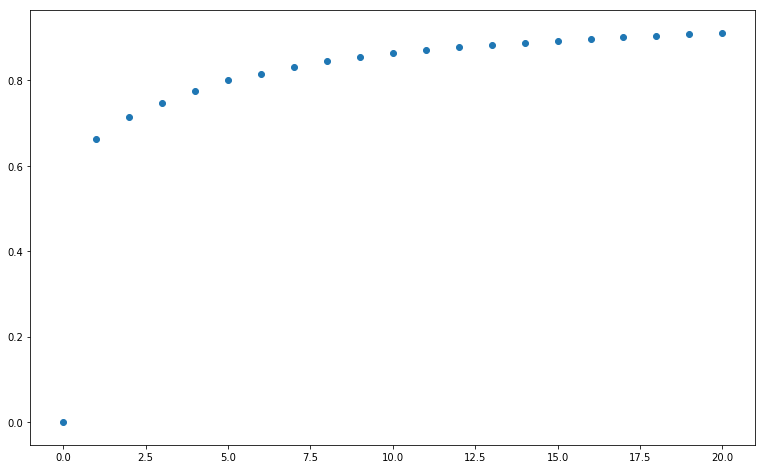

captured by PCA: 91.2%


In [25]:
plt.scatter(x=range(len(pca.explained_variance_ratio_)+1), 
            y=np.insert(pca.explained_variance_ratio_.cumsum(), 0, 0))
plt.show()
print(f"captured by PCA: {sum(pca.explained_variance_ratio_)*100:0.1f}%")

In [26]:
np_pca = pca.transform(all_df[cols_kmers])
df_reduc = pd.DataFrame(np_pca, columns=cols_reduc)
df_reduc = pd.concat([all_df[cols_spe].reset_index(inplace=False, drop=True), df_reduc], axis=1) # , ignore_index=True)
df_reduc["color_map"] = 0
for i, bacteria in enumerate(df_reduc.bacteria.unique()):
    df_reduc.loc[df_reduc["bacteria"] == bacteria, ['color_map']] = i
df_reduc.shape

(953798, 25)

In [ ]:
df_reduc.sample(1000).plot.scatter(x="component_1", y="component_2", s=1, c="color_map", colormap="nipy_spectral")  # gist_ncar
plt.show()
print(f"captured by PCA: {sum(pca.explained_variance_ratio_[:2])*100:0.1f}%")

In [28]:
df_reduc.sample(3)

,bacteria,fna,len_genome,start,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,...,pca_12,pca_13,pca_14,pca_15,pca_16,pca_17,pca_18,pca_19,pca_20,color_map
913102,Bradyrhizobium_japonicum_USDA_6_uid158851,NC_017249,9207384,8810000,-0.035,0.003,-0.006,0.002,0.010,-0.002,...,-0.002,0.002,-0.001,0.002,-0.001,0.003,0.001,-0.000,0.001,2669
473725,Neisseria_meningitidis_M01_240149_uid162079,NC_017514,2223518,1670000,-0.001,-0.002,-0.009,0.001,0.001,-0.005,...,0.004,-0.002,0.004,0.004,-0.004,-0.005,0.001,-0.001,-0.002,1386
95389,Desulfovibrio_vulgaris_RCH1_uid161961,NC_017310,3532052,230000,-0.037,-0.004,0.005,0.001,-0.002,0.002,...,0.002,-0.004,-0.008,-0.001,-0.007,-0.003,0.001,0.003,-0.000,294


### UMAP dimension reduction

In [ ]:
sample1 = all_df.sample(1000)
# sample2 = sample1 #all_df.sample(5000)

In [ ]:
# sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})
# reducer = umap.UMAP(n_components=components, metric='euclidean', n_neighbors=15)
reducer = umap.UMAP(n_components=components, metric='correlation', n_neighbors=20)
reducer.fit(sample1[cols_kmers])


<b>!! NEED MEMORY !!<b>

In [ ]:
sample2 = all_df.sample(5000)

In [ ]:
embedding = reducer.transform(sample2[cols_kmers])
embedding.shape

In [ ]:
df_reduc = pd.DataFrame(embedding, columns=cols_reduc)
df_reduc = pd.concat([sample2[cols_spe].reset_index(inplace=False, drop=True), df_reduc], axis=1) # , ignore_index=True)
# df_reduc["color_map"] = 0
# for i, bacteria in enumerate(df_reduc.bacteria.unique()):
#     df_reduc.loc[df_reduc["bacteria"] == bacteria, ['color_map']] = i
df_reduc.shape

In [ ]:
sns.scatterplot(
    x="component_1", y="component_2", c=x.cluster
    data=df_reduc,
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.3
)

In [ ]:
file_umap_data = f"/home/ubuntu/TMP/umap_data_{df_reduc.shape[0]}_{components}_float.pd"
df_reduc.to_pickle(file_umap_data)

In [ ]:
file_umap_model = f"/home/ubuntu/Data/kmer_freq/4mer/V4/UMAP/umap_model_{components}_float.pd"
pickle.dump(reducer, open(file_umap_model, 'wb'))

### Load data
Load reduced data

In [15]:
df_reduc = pd.read_pickle("/home/ubuntu/TMP/pca_data_953798_20_float.pd")

In [16]:
cols_pca = df_reduc.columns.to_list()[4:-2]

In [35]:
f_model_kmeans = "/home/ubuntu/Data/kmer_freq/4mer/V4/clustering/10_kmeans_256_2019-06-21_09-31.pkl"

In [36]:
with open(f_model_kmeans, 'rb') as f:
    kmeans = pickle.load(f)


# Classification into bins

In [17]:
# KNN, RBF SVM, Gaussian Process, RF, NN, Naive Bayes, 
from sklearn.metrics import classification_report
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis


In [17]:
from joblib import Parallel, delayed

In [18]:
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]
classifiers = [
    KNeighborsClassifier(),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

In [56]:
sample1 = df_reduc.sample(100)

X = sample1[cols_pca].copy()
y = sample1["cluster"].to_list()

In [57]:
h = .02  # step size in the mesh

# preprocess dataset, split into training and test part
def pre_proc_plt(X, y):
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.2, random_state=seed)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(1, len(classifiers) + 1, i)
    ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, #cmap=cm_bright,
               edgecolors='k')
    # Plot the testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, #cmap=cm_bright, 
               alpha=0.6, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    
    return X, y

In [58]:
def try_classifier(i, name, clf):
    start_time = time()
    
    ax = plt.subplot(1, len(classifiers) + 1, i)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    try:
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)
    except:
        pass

    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, #cmap=cm_bright,
               edgecolors='k')
    # Plot the testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, #cmap=cm_bright,
               edgecolors='k', alpha=0.6)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(name)
    ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
            size=15, horizontalalignment='right')
    
    end_time = time()
    p_str = f'Classification ({name}) took {end_time - start_time:.2f} s'
    print(p_str)
    plt.text(-0.0, 0.0, p_str, fontsize=12)
    ax.text(-0.0, 0.0, p_str, fontsize=12)
    
    i += 1

In [ ]:
figure = plt.figure(figsize=(27, 9))
i = 1
X, y = pre_proc_plt(X, y)

# iterate over classifiers
Parallel(n_jobs=4)(delayed(try_classifier)(i+1, name, clf) \
                   for i, (name, cls) in tqdm(enumerate(zip(names, classifiers)), total=len(names)))

plt.tight_layout()
plt.show()

In [24]:
kmeans.cluster_centers_.shape

(10, 256)

In [21]:
df_reduc.sample(5)

,bacteria,fna,len_genome,start,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,...,pca_13,pca_14,pca_15,pca_16,pca_17,pca_18,pca_19,pca_20,color_map,cluster
9332,Salmonella_enterica_serovar_Gallinarum_287_91_...,NC_011274,4658697,3290000,-0.009,-0.000,-0.011,-0.001,-0.007,-0.002,...,0.003,0.003,0.002,0.005,-0.001,-0.001,0.001,-0.004,26,0
436250,Pyrococcus_abyssi_GE5_uid62903,NC_000868,1765118,530000,0.020,-0.012,0.014,0.000,0.011,-0.004,...,0.000,0.005,0.000,0.002,-0.006,-0.000,-0.001,-0.001,1276,7
400008,Mycobacterium_avium_104_uid57693,NC_008595,5475491,2640000,-0.037,0.000,0.001,0.003,0.005,0.006,...,0.000,-0.001,-0.001,-0.001,0.002,0.003,-0.003,-0.002,1171,2
774381,Enterobacter_cloacae_NCTC_9394_uid197202,NC_021046,4908759,1860000,-0.007,-0.007,-0.004,0.007,-0.007,0.001,...,0.002,0.000,-0.002,0.003,-0.001,0.002,0.001,-0.001,2269,0
648088,Methylobacterium_nodulans_ORS_2060_uid59023,NC_011894,7772460,5040000,-0.053,0.014,0.003,0.006,0.003,-0.007,...,0.004,0.002,0.001,0.003,0.003,0.006,0.002,-0.000,1895,8


In [77]:
df_reduc.sample(5)[["bacteria", "fna", "start", "cluster"]]

,bacteria,fna,start,cluster
420123,Bacillus_thuringiensis_BMB171_uid49135,NC_014171,1510000,1
305862,Bacteroides_fragilis_YCH46_uid58195,NC_006297,20000,4
908103,Spirochaeta_smaragdinae_DSM_11293_uid51369,NC_014364,4300000,7
16256,Sinorhizobium_meliloti_SM11_uid159685,NC_017325,3500000,2
746392,Candidatus_Nitrospira_defluvii_uid51175,NC_014355,2780000,0


In [80]:
df_reduc[df_reduc.index == 908103]

,bacteria,fna,len_genome,start,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,...,pca_13,pca_14,pca_15,pca_16,pca_17,pca_18,pca_19,pca_20,color_map,cluster
908103,Spirochaeta_smaragdinae_DSM_11293_uid51369,NC_014364,4653970,4300000,0.008,-0.009,0.007,0.001,0.007,-0.011,...,0.002,0.003,0.003,-0.003,-0.002,-0.000,-0.003,0.003,2655,7


In [79]:
kmeans.predict(df_reduc[df_reduc.index == 908103][cols_pca])

array([3], dtype=int32)

# Clustering

https://nbviewer.jupyter.org/github/scikit-learn-contrib/hdbscan/blob/master/notebooks/Comparing%20Clustering%20Algorithms.ipynb

In [15]:
import sklearn.cluster as cluster
import scipy.cluster.hierarchy as sch
import seaborn as sns
import hdbscan

In [16]:
now = lambda : dt.now().strftime("%Y-%m-%d_%H-%M")

In [17]:
now()

'2019-07-11_08-43'

In [18]:
n_clusters = 10

In [ ]:
df_reduc.shape

In [ ]:
x = df_reduc.sample(10000)

In [ ]:
x.sample(3)

In [27]:
# sns.set_context('poster')
sns.set_context("paper")
# sns.set_context("notebook", font_scale=1.25)
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 10, 'linewidths':0}

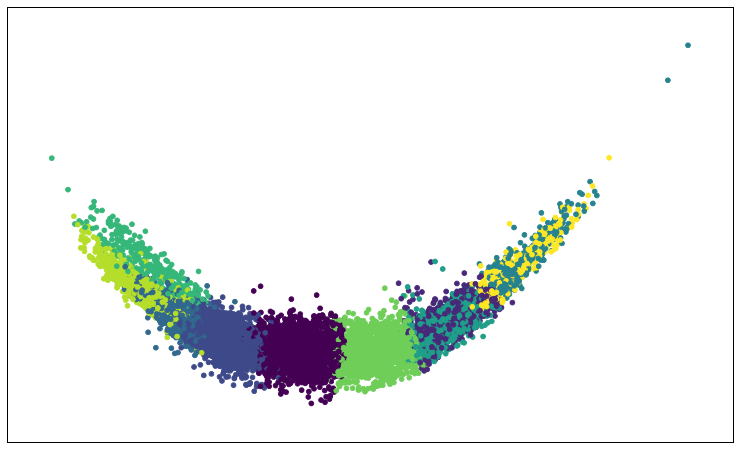

In [28]:
plt.scatter(x.component_1, x.component_2, c=x.cluster)  #, **plot_kwds)
frame = plt.gca()
frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(False)

In [29]:
df_reduc.sample(3)

,bacteria,fna,len_genome,start,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,...,pca_13,pca_14,pca_15,pca_16,pca_17,pca_18,pca_19,pca_20,color_map,cluster
187583,Pseudomonas_aeruginosa_PA1R_uid228932,NC_022806,6309305,1950000,-0.031,-0.005,0.003,0.006,-0.007,-0.003,...,0.003,-0.000,-0.005,0.003,-0.001,0.001,0.001,-0.001,562,2
582571,Bdellovibrio_bacteriovorus_HD100_uid61595,NC_005363,3782950,2240000,0.005,-0.012,-0.001,0.006,-0.000,-0.001,...,-0.003,-0.002,0.001,-0.001,0.004,-0.004,-0.001,-0.002,1714,0
68811,Anabaena_variabilis_ATCC_29413_uid58043,NC_007413,6365727,5240000,0.033,-0.004,0.003,-0.003,0.003,0.001,...,0.000,0.001,0.002,0.004,0.002,0.001,-0.003,-0.002,204,1


In [32]:
df_reduc.cluster.value_counts()

7    165412
0    159506
2    146446
1    108187
5     93455
3     88695
8     84395
9     40371
4     37338
6     29993
Name: cluster, dtype: int64

In [34]:
df_reduc.cluster.count()

953798

In [31]:
for clu in df_reduc.cluster.unique():
    print(df_reduc[df_reduc["cluster"] == clu].count)

<bound method DataFrame.count of                                               bacteria        fna  len_genome  \
0           Propionibacterium_acnes_KPA171202_uid58101  NC_006085     2560265   
2           Propionibacterium_acnes_KPA171202_uid58101  NC_006085     2560265   
24          Propionibacterium_acnes_KPA171202_uid58101  NC_006085     2560265   
60          Propionibacterium_acnes_KPA171202_uid58101  NC_006085     2560265   
75          Propionibacterium_acnes_KPA171202_uid58101  NC_006085     2560265   
86          Propionibacterium_acnes_KPA171202_uid58101  NC_006085     2560265   
87          Propionibacterium_acnes_KPA171202_uid58101  NC_006085     2560265   
93          Propionibacterium_acnes_KPA171202_uid58101  NC_006085     2560265   
94          Propionibacterium_acnes_KPA171202_uid58101  NC_006085     2560265   
124         Propionibacterium_acnes_KPA171202_uid58101  NC_006085     2560265   
132         Propionibacterium_acnes_KPA171202_uid58101  NC_006085     256026

<bound method DataFrame.count of                                                  bacteria        fna  \
357               Chamaesiphon_minutus_PCC_6605_uid183005  NC_019697   
374               Chamaesiphon_minutus_PCC_6605_uid183005  NC_019697   
436               Chamaesiphon_minutus_PCC_6605_uid183005  NC_019697   
463               Chamaesiphon_minutus_PCC_6605_uid183005  NC_019697   
616               Chamaesiphon_minutus_PCC_6605_uid183005  NC_019697   
751               Chamaesiphon_minutus_PCC_6605_uid183005  NC_019697   
752               Chamaesiphon_minutus_PCC_6605_uid183005  NC_019697   
753               Chamaesiphon_minutus_PCC_6605_uid183005  NC_019697   
882               Chamaesiphon_minutus_PCC_6605_uid183005  NC_019697   
892               Chamaesiphon_minutus_PCC_6605_uid183005  NC_020053   
927               Chamaesiphon_minutus_PCC_6605_uid183005  NC_020053   
1130             Geobacter_sulfurreducens_KN400_uid161977  NC_017454   
1339      Streptococcus_thermop

<bound method DataFrame.count of                                               bacteria        fna  len_genome  \
1679           Mycobacterium_bovis_BCG_Mexico_uid86889  NC_016804     4350386   
1682           Mycobacterium_bovis_BCG_Mexico_uid86889  NC_016804     4350386   
1685           Mycobacterium_bovis_BCG_Mexico_uid86889  NC_016804     4350386   
1686           Mycobacterium_bovis_BCG_Mexico_uid86889  NC_016804     4350386   
1694           Mycobacterium_bovis_BCG_Mexico_uid86889  NC_016804     4350386   
1696           Mycobacterium_bovis_BCG_Mexico_uid86889  NC_016804     4350386   
1698           Mycobacterium_bovis_BCG_Mexico_uid86889  NC_016804     4350386   
1701           Mycobacterium_bovis_BCG_Mexico_uid86889  NC_016804     4350386   
1704           Mycobacterium_bovis_BCG_Mexico_uid86889  NC_016804     4350386   
1705           Mycobacterium_bovis_BCG_Mexico_uid86889  NC_016804     4350386   
1706           Mycobacterium_bovis_BCG_Mexico_uid86889  NC_016804     435038

In [50]:
bac_sample = df_reduc.sample(3).bacteria.unique().to_list()

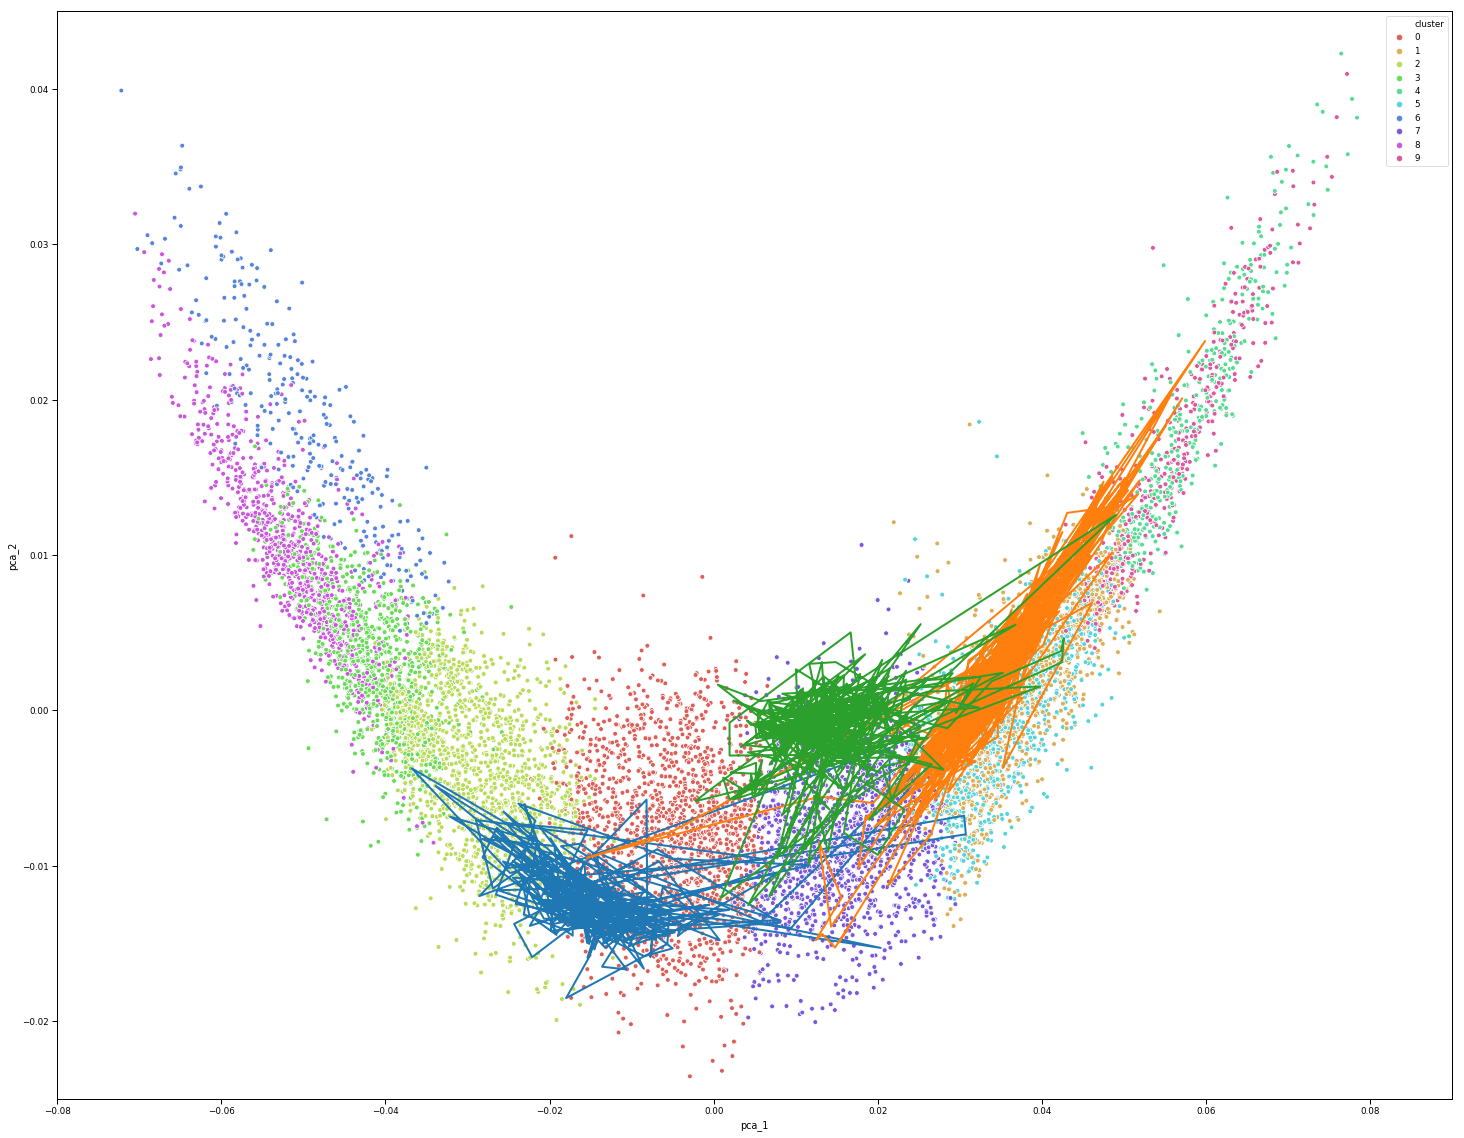

In [51]:
plt.figure(figsize=(25,20))
plt.axis([-0.08, 0.09, -0.025, 0.045])
sns.scatterplot(
    x="component_1", y="component_2", data=x,
    hue="cluster", palette=sns.color_palette("hls", 10), alpha=1,
    legend="full"
)
# plt.scatter(x.component_1, x.component_2, c=x.cluster, s=50)

for bac in bac_sample[::-1]:
    longest = df_reduc[df_reduc["bacteria"] == bac].len_genome.max()
    plt.plot('component_1', 'component_2', linewidth=2.0, 
              data=df_reduc[(df_reduc.bacteria == bac) & 
                          (df_reduc.len_genome == longest)])

In [30]:
def compute_clusters(data, algorithm, args, kwds, col_plot=(0,1)):
    start_time = time()
    labels = algorithm(*args, **kwds).fit_predict(data)
    end_time = time()
    return labels

In [31]:
def plot_clusters(data):
    sample = data.sample(1000)
    
    palette = sns.color_palette('deep', np.unique(sample.cluster).max() + 1)
    colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in sample.cluster]
    
    plot_kwds = {'alpha' : 0.25, 's' : 20, 'linewidths':0}
    
    plt.scatter(sample.component_1, sample.component_2, c=colors, **plot_kwds)
#     sns.scatterplot(x=sample.columns[0], y=sample.columns[1], data=sample, legend="full", **plot_kwds)
#     frame = plt.gca()
#     frame.axes.get_xaxis().set_visible(False)
#     frame.axes.get_yaxis().set_visible(False)
    plt.title('Clusters found by {}'.format(str(algorithm.__name__)), fontsize=24)
    plt.text(-0.5, 0.7, 'Clustering took {:.2f} s'.format(end_time - start_time), fontsize=14)

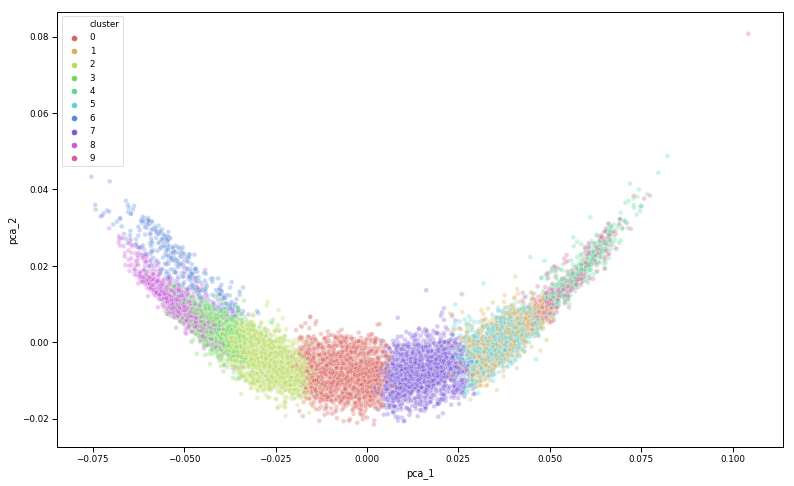

In [32]:
sns.scatterplot(
    x="component_1", y="component_2",
    data=x,
    hue="cluster",
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.3
)

In [33]:
df_reduc.sample(5)

,bacteria,fna,len_genome,start,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,...,pca_13,pca_14,pca_15,pca_16,pca_17,pca_18,pca_19,pca_20,color_map,cluster
721813,Mycobacterium_tuberculosis_RGTB423_uid162179,NC_017528,4406587,340000,-0.040,0.003,0.002,-0.002,-0.003,0.007,...,-0.001,0.003,-0.003,-0.002,0.002,-0.001,-0.005,0.002,2120,3
776358,Actinoplanes_N902_109_uid202219,NC_021191,9228054,7530000,-0.050,0.007,0.009,-0.001,-0.003,0.006,...,-0.002,0.002,-0.001,-0.001,0.001,-0.001,0.001,0.001,2272,8
480130,Klebsiella_pneumoniae_rhinoscleromatis_SB3432_...,NC_021232,5270770,2960000,-0.024,-0.000,-0.000,0.001,-0.010,0.000,...,0.003,0.005,0.002,0.002,0.001,0.000,-0.002,-0.003,1402,2
305327,Micavibrio_EPB_uid194120,NC_020812,2458610,840000,0.001,-0.007,-0.004,0.003,-0.003,0.001,...,-0.004,-0.003,0.000,-0.001,-0.002,0.001,-0.002,0.001,901,0
325654,Rhodospirillum_photometricum_uid159003,NC_017059,3876289,1990000,-0.025,-0.001,0.006,-0.002,-0.003,-0.006,...,-0.000,0.002,0.002,-0.001,-0.003,-0.002,0.002,-0.002,963,2


In [34]:
x.shape

(10000, 26)

## t-SNE

In [35]:
def compute_tsne(data, labels, perplexity=30, n_iter=1000):
    X_embedded = TSNE(n_components=2, verbose=1, perplexity=perplexity, n_iter=n_iter).fit_transform(data)
    tsne_df = pd.DataFrame(X_embedded, columns=["component1", "component2"], index=data.index)
    tsne_df["cluster"] = labels
#     data["component1"] = X_embedded[:,0]
#     data["component2"] = X_embedded[:,1]
    return tsne_df

In [36]:
def save_plot_tsne(tsne_df, perplexity):
    plt.figure()
    ax = sns.scatterplot(
            x="component1", y="component2",
            data=tsne_df,
            hue="cluster",
            palette=sns.color_palette("hls", 10),
            legend="full",
            alpha=0.3,
    )
    ax.set_title(f"t-SNE with perplexity:{perplexity} and n_iter={n_iter}")
    plt.savefig(f"/home/ubuntu/Data/Presentations/Clustering_t-SNE/plot-perplexity_{perplexity:03}-n_iter_{n_iter:04}.png")
    print(f"Saved figure: plot-perplexity_{perplexity:03}-n_iter_{n_iter:04}.png")
    # plt.show()

In [74]:
all_df["cluster"] = df_reduc.cluster.values

In [75]:
df_reduc.tail()

,bacteria,fna,len_genome,start,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,...,pca_13,pca_14,pca_15,pca_16,pca_17,pca_18,pca_19,pca_20,color_map,cluster
953793,Mycoplasma_gallisepticum_CA06_2006_052_5_2P_ui...,NC_018412,976412,920000,0.057,0.016,-0.000,0.003,-0.001,0.007,...,-0.002,0.004,-0.004,0.009,0.000,-0.004,0.001,-0.001,2781,9
953794,Mycoplasma_gallisepticum_CA06_2006_052_5_2P_ui...,NC_018412,976412,930000,0.057,0.016,0.000,-0.003,-0.001,0.004,...,0.001,0.004,0.000,0.007,0.003,0.001,0.000,-0.003,2781,4
953795,Mycoplasma_gallisepticum_CA06_2006_052_5_2P_ui...,NC_018412,976412,940000,0.054,0.012,-0.001,0.008,-0.001,0.007,...,-0.001,0.005,0.001,0.008,0.001,0.001,0.001,0.000,2781,9
953796,Mycoplasma_gallisepticum_CA06_2006_052_5_2P_ui...,NC_018412,976412,950000,0.051,0.008,-0.002,0.011,-0.001,0.010,...,0.000,0.004,-0.000,0.008,0.006,-0.003,0.000,-0.001,2781,9
953797,Mycoplasma_gallisepticum_CA06_2006_052_5_2P_ui...,NC_018412,976412,960000,0.053,0.013,-0.002,0.012,0.001,0.006,...,-0.001,0.001,-0.000,0.007,0.003,-0.002,-0.002,-0.000,2781,9


In [76]:
all_df.tail()

,bacteria,fna,len_genome,start,AAAA,AAAC,AAAG,AAAT,AACA,AACC,...,TTCT,TTGA,TTGC,TTGG,TTGT,TTTA,TTTC,TTTG,TTTT,cluster
92,Mycoplasma_gallisepticum_CA06_2006_052_5_2P_ui...,NC_018412,976412,920000,157.000,60.000,80.000,126.000,64.000,42.000,...,90.000,110.000,32.000,45.000,76.000,196.000,82.000,96.000,235.000,9
93,Mycoplasma_gallisepticum_CA06_2006_052_5_2P_ui...,NC_018412,976412,930000,230.000,94.000,111.000,133.000,71.000,49.000,...,81.000,85.000,30.000,44.000,60.000,190.000,60.000,63.000,203.000,4
94,Mycoplasma_gallisepticum_CA06_2006_052_5_2P_ui...,NC_018412,976412,940000,151.000,86.000,99.000,132.000,64.000,47.000,...,117.000,86.000,38.000,51.000,96.000,181.000,99.000,75.000,211.000,9
95,Mycoplasma_gallisepticum_CA06_2006_052_5_2P_ui...,NC_018412,976412,950000,89.000,91.000,67.000,95.000,71.000,56.000,...,103.000,87.000,45.000,52.000,90.000,172.000,76.000,92.000,242.000,9
96,Mycoplasma_gallisepticum_CA06_2006_052_5_2P_ui...,NC_018412,976412,960000,134.000,82.000,66.000,117.000,71.000,42.000,...,126.000,88.000,38.000,57.000,86.000,167.000,94.000,96.000,261.000,9


In [112]:
sample1 = all_df.sample(5000)
sample2 = sample1 #all_df.sample(5000)

In [113]:
# sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})
reducer = umap.UMAP(n_components=20)
reducer.fit(sample1[cols_kmers])


/home/ubuntu/.pyenv/versions/3.7.3/envs/py373/lib/python3.7/site-packages/numba/compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../.pyenv/versions/3.7.3/envs/py373/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
   learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
   metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
   n_neighbors=15, negative_sample_rate=5, random_state=None,
   repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
   target_metric='categorical', target_metric_kwds=None,
   target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
   transform_seed=42, verbose=False)

In [114]:
embedding = reducer.transform(sample2[cols_kmers])
embedding.shape

(5000, 2)

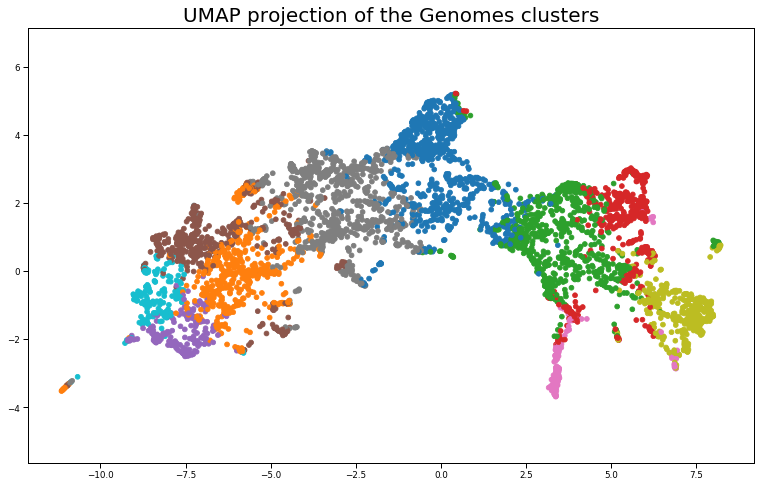

In [115]:
plt.scatter(embedding[:, 0], embedding[:, 1], 
            c=[sns.color_palette()[x] for x in sample2.cluster])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Genomes clusters', fontsize=20);

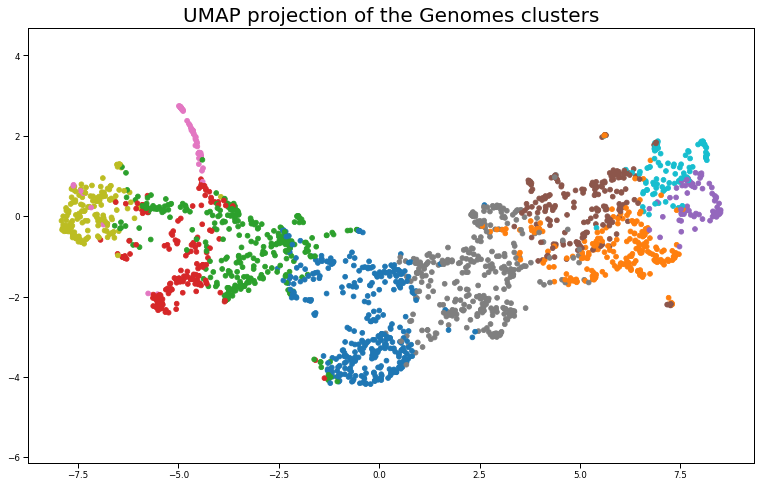

In [111]:
plt.scatter(embedding[:, 0], embedding[:, 1], 
            c=[sns.color_palette()[x] for x in sample2.cluster])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Genomes clusters', fontsize=20);

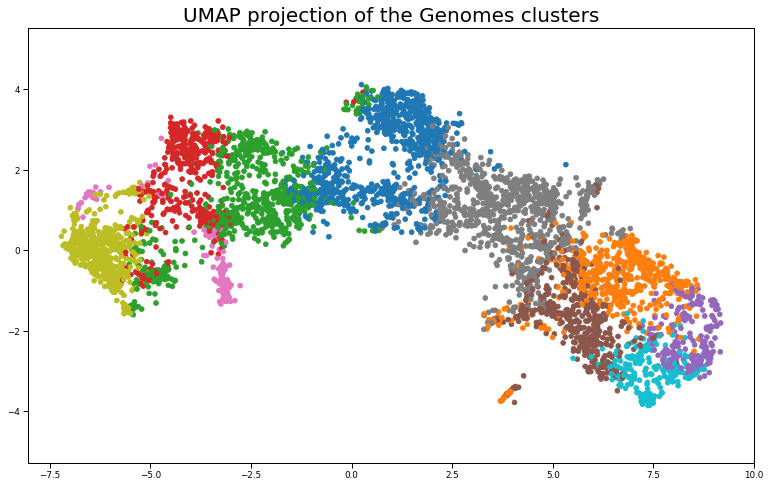

In [94]:
plt.scatter(embedding[:, 0], embedding[:, 1], 
            c=[sns.color_palette()[x] for x in sample2.cluster])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Genomes clusters', fontsize=20);

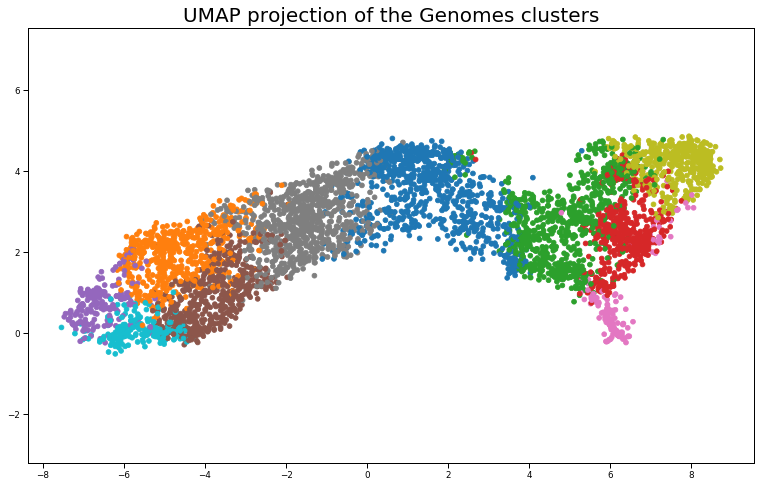

In [84]:
plt.scatter(embedding[:, 0], embedding[:, 1], 
            c=[sns.color_palette()[x] for x in sample2.cluster])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Genomes clusters', fontsize=20);

In [39]:
dat = df_reduc.sample(200)
n_iter=1000
for perplex in tqdm([2, 5, 10, 20, 30, 50, 70, 95, 100]):
    tsne_df = compute_tsne(dat[cols_reduc], dat[["cluster"]], perplexity=perplex)
#     save_plot_tsne(tsne_df, perplex)

[t-SNE] Computing 7 nearest neighbors...
[t-SNE] Indexed 200 samples in 0.002s...
[t-SNE] Computed neighbors for 200 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 200 / 200
[t-SNE] Mean sigma: 0.004020
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.926468
[t-SNE] KL divergence after 1000 iterations: 0.536656
[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 200 samples in 0.000s...
[t-SNE] Computed neighbors for 200 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 200 / 200
[t-SNE] Mean sigma: 0.006956
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.627556
[t-SNE] KL divergence after 1000 iterations: 0.565988
[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 200 samples in 0.000s...
[t-SNE] Computed neighbors for 200 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 200 / 200
[t-SNE] Mean sigma: 0.009036
[t-SNE] KL divergence after 250 iteration

Learn the clusters

## Checking if clusters make sense
counting windows of genomes per cluster (how are they split)

In [188]:
def windows_counts_plot():
    # computing values
    x_val = []
    y_val = []
    bac_name = []
    plot_x = 3; plot_y = 4
    nb_examples = plot_x * plot_y
    for bac in random.choices(df_reduc.bacteria.unique(), k=nb_examples):
        clusters = Counter(df_reduc[(df_reduc.bacteria == bac) & (df_reduc.genome_plasmid == "genome")].cluster)
        clusters = dict(clusters)
        for key in range(10):
            if key not in clusters.keys():
                clusters[key] = 0
        x_val.append(list(clusters.keys()))
        y_val.append(list(clusters.values()))
        bac_name.append(bac)
    
    # plotting
    plt.figure()
    for i in range(nb_examples):
        plt.subplot(plot_x, plot_y, i+1)
        sns.barplot(x_val[i], y_val[i])
        plt.title("_".join(bac_name[i].split("_")[0:2]))

        if i+1 == 10: plt.xlabel("Cluster ID")
        if i+1 == 5: plt.ylabel("# windows assigned")

        if i+1 >= 9: plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True)
        else:        plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)


In [40]:
sns.set_context("paper")

Saved figure: 00.png
Saved figure: 01.png
Saved figure: 02.png
Saved figure: 03.png
Saved figure: 04.png
Saved figure: 05.png
Saved figure: 06.png
Saved figure: 07.png
Saved figure: 08.png
Saved figure: 09.png


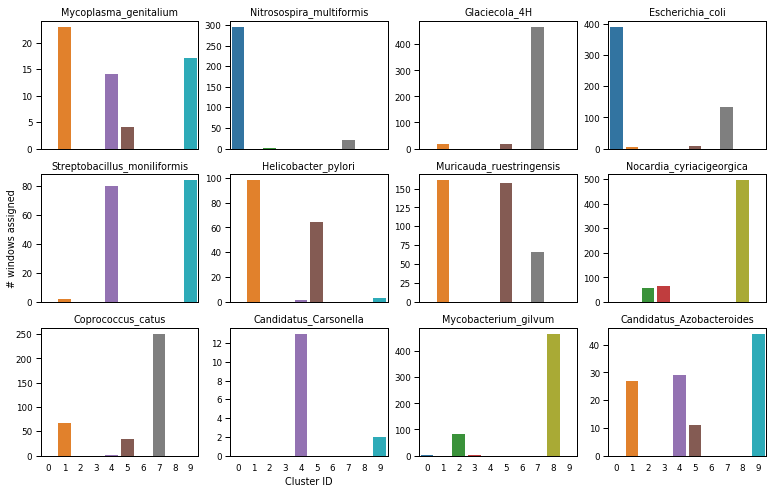

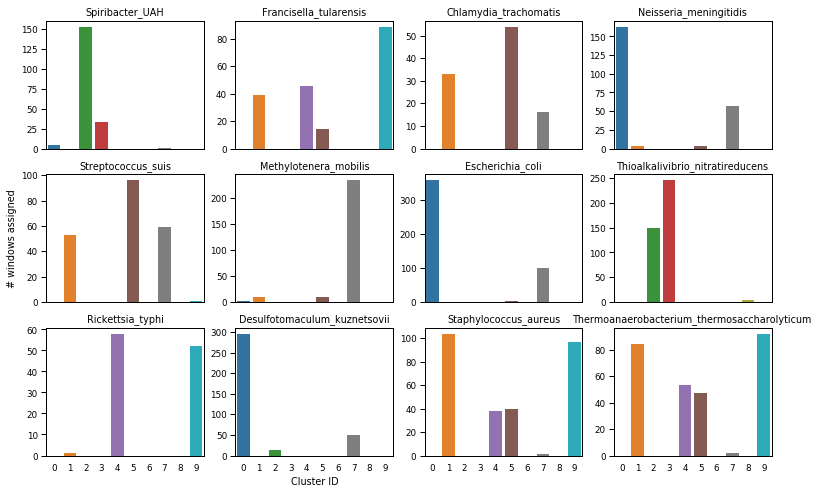

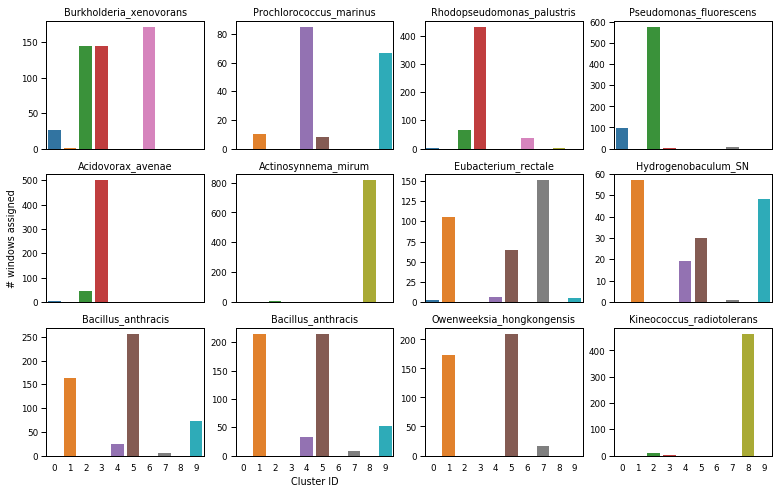

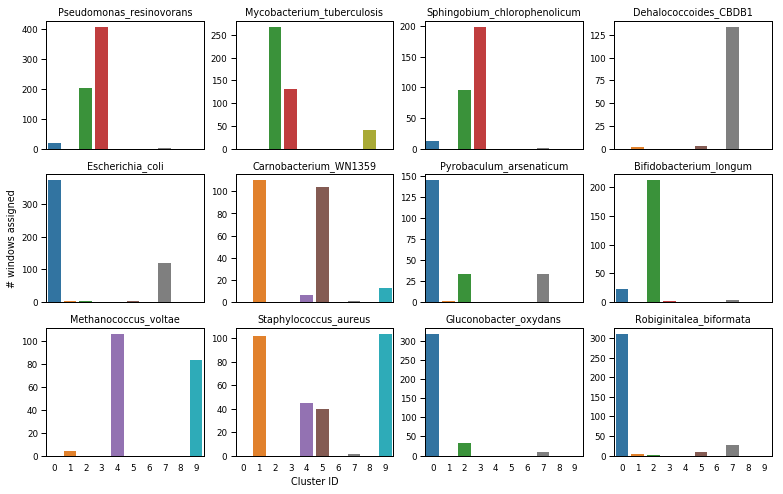

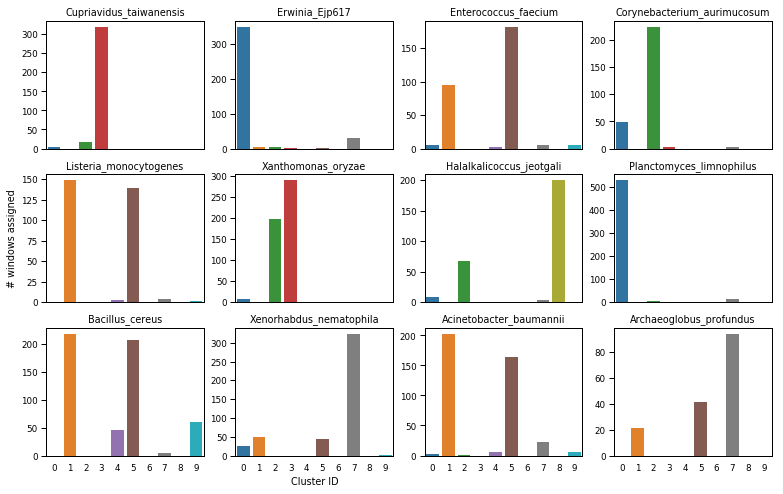

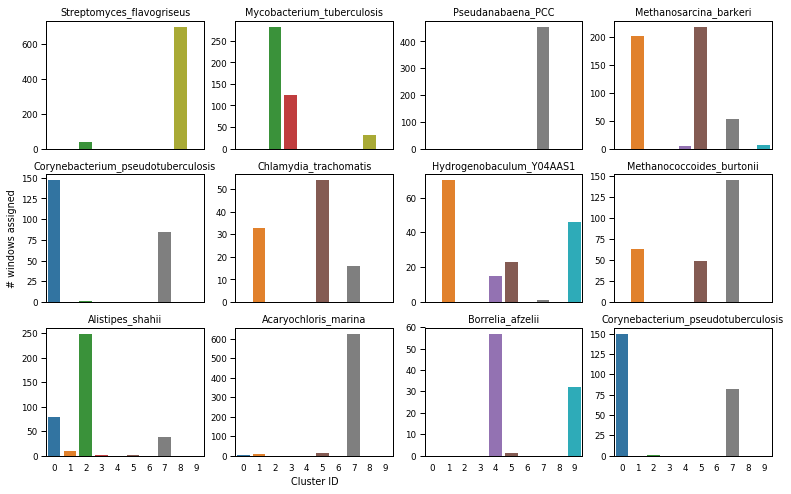

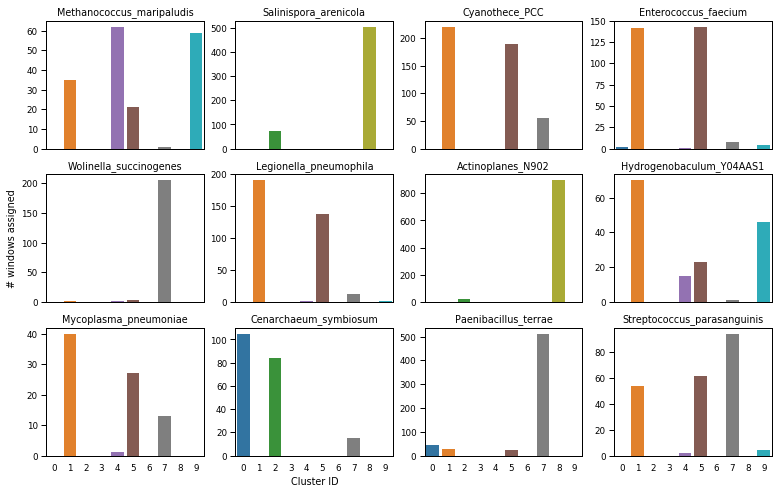

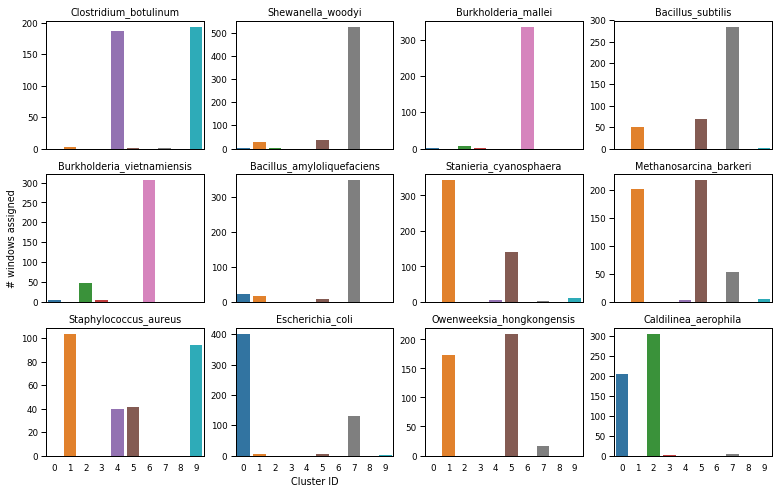

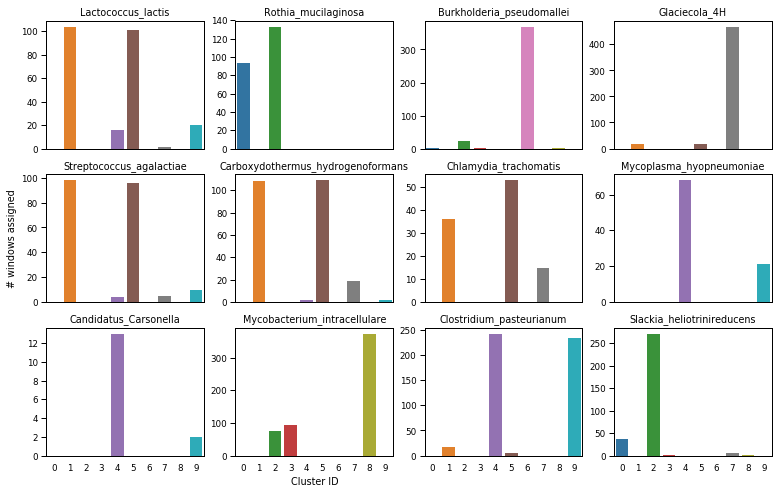

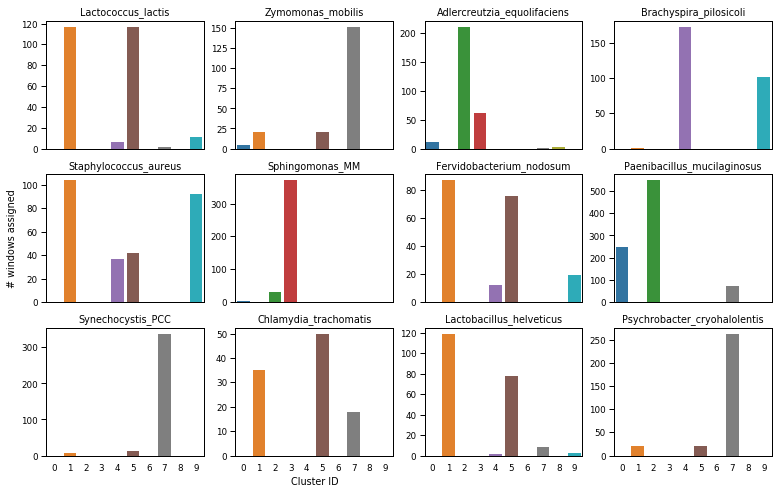

In [190]:
for i in tqdm(range(10)):
    windows_counts_plot()
    plt.savefig(f"/home/ubuntu/Data/Presentations/genomes_window_counts/{i:02}.png")
    print(f"Saved figure: {i:02}.png")

## K Means

In [40]:
kmeans = KMeans(n_clusters=n_clusters, n_jobs=-1, random_state=seed)

In [41]:
now()

'2019-06-26_07-19'

In [42]:
all_df.head(3)

,bacteria,fna,len_genome,start,AAAA,AAAC,AAAG,AAAT,AACA,AACC,...,TTCT,TTGA,TTGC,TTGG,TTGT,TTTA,TTTC,TTTG,TTTT,cluster
0,Propionibacterium_acnes_KPA171202_uid58101,NC_006085,2560265,0,0.002,0.002,0.002,0.003,0.002,0.004,...,0.002,0.005,0.005,0.004,0.003,0.001,0.003,0.003,0.003,0
1,Propionibacterium_acnes_KPA171202_uid58101,NC_006085,2560265,10000,0.002,0.002,0.002,0.001,0.002,0.003,...,0.002,0.004,0.004,0.004,0.002,0.001,0.002,0.002,0.001,0
2,Propionibacterium_acnes_KPA171202_uid58101,NC_006085,2560265,20000,0.002,0.002,0.003,0.002,0.003,0.002,...,0.004,0.004,0.005,0.006,0.005,0.001,0.005,0.004,0.004,6


In [49]:
pd.set_option('display.max_columns', 30)

In [43]:
start = time()
kmeans.fit(all_df[cols_kmers])
print(f"took {time() - start:.2f} s")

took 268.49 s


In [44]:
with open(f"/home/ubuntu/Data/kmer_freq/4mer/V4/clustering/{n_clusters}_kmeans_256_LenScale_{now()}.pkl", 'wb') as f: 
    pickle.dump(kmeans, f)

In [45]:
start = time()
predicted = kmeans.predict(all_df[cols_kmers])
print(f"took {time() - start:.2f} s")

took 3.75 s


In [46]:
predicted[:5]

array([7, 7, 2, 7, 7], dtype=int32)

In [47]:
all_df["cluster"] = predicted

In [ ]:
with open(f"/home/ubuntu/Data/kmer_freq/4mer/V4/clustering/{n_clusters}_kmeans_256_{now()}.pkl", 'wb') as f: 
    pickle.dump(kmeans, f)

In [107]:
df_reduc["y_km"] = y_km

ValueError: Length of values does not match length of index

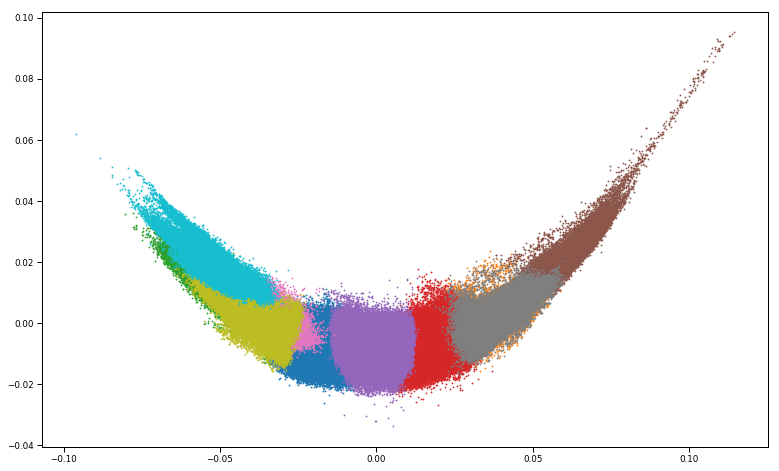

In [54]:
for c in range(n_clusters):
    plt.scatter(df_reduc["component_1"][y_km == c], df_reduc["component_2"][y_km == c], s=1)

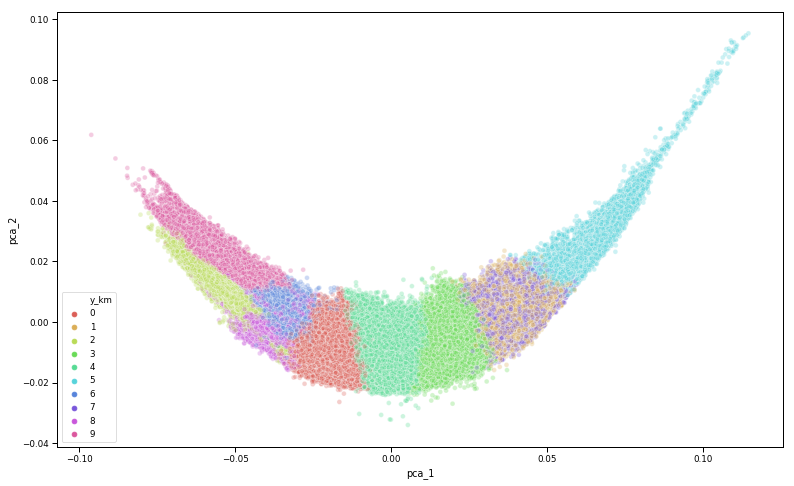

In [58]:
sns.scatterplot(
    x="component_1", y="component_2",
    data=df_reduc,
    hue="y_km",
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.3
)

## Agglomerate clustering

In [77]:
data = x[cols_lda].sample(10000)

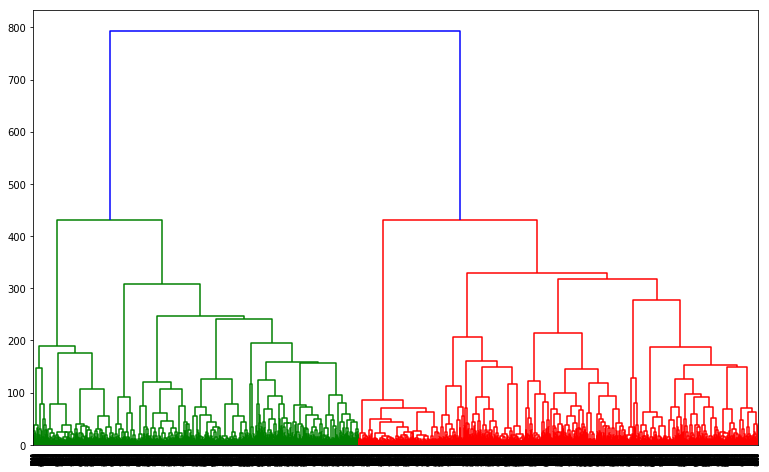

In [78]:
# create dendrogram
dendrogram = sch.dendrogram(sch.linkage(data, method='ward'))
# create clusters
print("Create clusters...")
hc = AgglomerativeClustering(n_clusters=n_clusters, affinity = 'euclidean', linkage = 'ward')
# save clusters for chart
print("save them")
y_hc = hc.fit_predict(data)

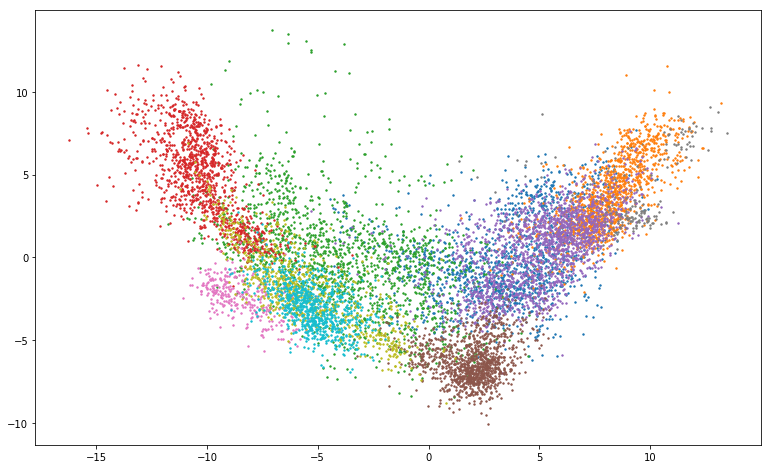

In [81]:
for c in range(n_clusters):
    plt.scatter(data["lda_1"][y_hc == c], data["lda_2"][y_hc == c], s=2)

In [85]:
with open(f"/home/ubuntu/Data/kmer_freq/4mer/V4/clustering/{n_clusters}_agglo_{now()}.pkl", 'wb') as f: 
    pickle.dump(hc, f)

## Mini Batch KMeans

In [26]:
minikm = MiniBatchKMeans(n_clusters=n_clusters, random_state=seed, batch_size=1000, max_iter=100)

In [27]:
start = time()
minikm.fit(all_df[cols_kmers])
print(f"took {time() - start:.2f} s")

took 9.20 s


In [28]:
start = time()
y_mini = minikm.predict(all_df[cols_kmers])
print(f"took {time() - start:.2f} s")

took 4.27 s


In [28]:
with open(f"/home/ubuntu/Data/kmer_freq/4mer/V4/clustering/{n_clusters}_minikm_256_LenScale_{now()}.pkl", 'wb') as f: 
    pickle.dump(minikm, f)

In [29]:
y_mini

array([5, 5, 0, ..., 8, 8, 8], dtype=int32)

In [29]:
all_df["cluster"] = y_mini

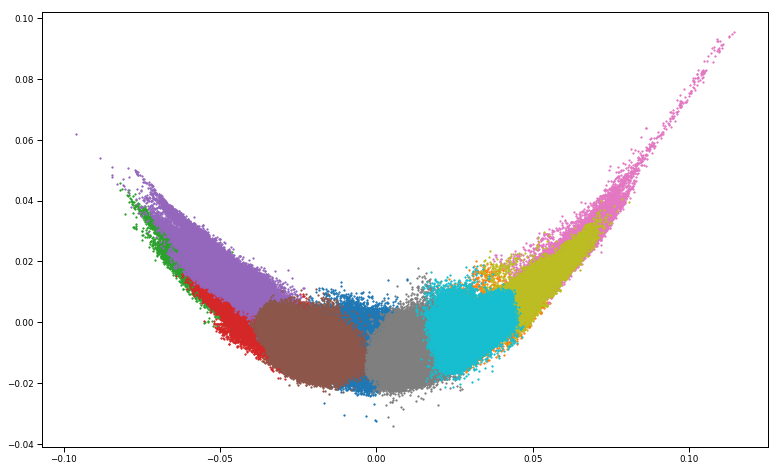

In [80]:
for c in range(n_clusters):
    plt.scatter(df_reduc["component_1"][y_mini == c], df_reduc["component_2"][y_mini == c], s=2)

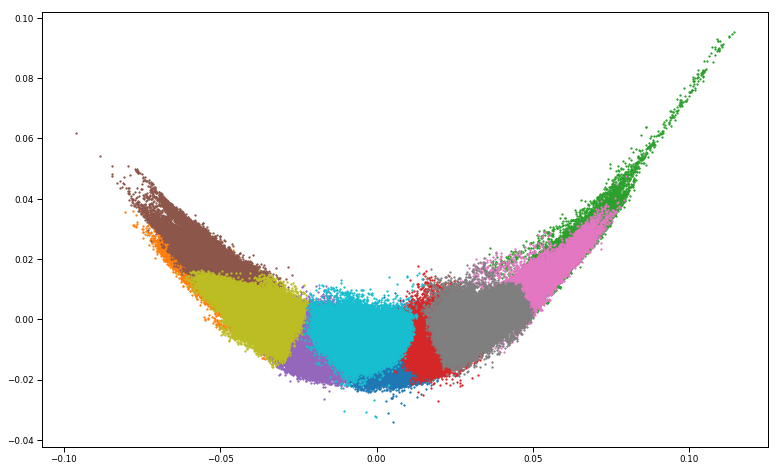

In [73]:
for c in range(n_clusters):
    plt.scatter(df_reduc["component_1"][y_mini == c], df_reduc["component_2"][y_mini == c], s=2)

In [75]:
row_sums = all_df[cols_kmers].sum(axis=1)
row_sums[row_sums == 0] = 1.0

In [76]:
all_df[cols_kmers] = all_df[cols_kmers].div(row_sums, axis=0)

## Combining results

In [104]:
class Cluster:
    def __init__(self, name, model, prediction):
        self.name = name
        self.model = model
        self.pred = prediction
        

In [105]:
models = [
    Cluster("kmeans", kmeans, y_km),
    Cluster("agglo", hc, y_hc),
    Cluster("minikm", minikm, y_mini),
]

# Evaluation

In [23]:
# 10_kmeans_256_2019-06-21_09-31.pkl
# 10_kmeans_256_LenScale_2019-06-26_02-25.pkl
with open("/home/ubuntu/Data/kmer_freq/4mer/V4/clustering/"
          "10_kmeans_256_LenScale_2019-06-26_07-23.pkl", 'rb') as f: 
    predictor = pickle.load(f)

In [25]:
start = time()
y_km = predictor.transform(all_df[cols_kmers])
# all_df["cluster"] = y_km
print(f"took {time() - start:.2f} s")

took 76.48 s


In [47]:
pd.DataFrame(y_km).describe()

,0,1,2,3,4,5,6,7,8,9
count,"953,798.000","953,798.000","953,798.000","953,798.000","953,798.000","953,798.000","953,798.000","953,798.000","953,798.000","953,798.000"
mean,0.051,0.054,0.041,0.070,0.054,0.044,0.053,0.044,0.064,0.068
std,0.024,0.026,0.016,0.029,0.026,0.020,0.026,0.019,0.029,0.027
min,0.011,0.011,0.010,0.010,0.011,0.011,0.010,0.010,0.010,0.011
25%,0.030,0.031,0.028,0.045,0.031,0.027,0.031,0.028,0.038,0.044
50%,0.046,0.048,0.040,0.069,0.050,0.039,0.048,0.040,0.062,0.067
75%,0.071,0.076,0.052,0.097,0.076,0.059,0.076,0.057,0.088,0.091
max,0.198,0.174,0.177,0.186,0.200,0.165,0.175,0.189,0.206,0.206


In [31]:
all_df.sample(3)

,bacteria,fna,len_genome,start,AAAA,AAAC,AAAG,AAAT,AACA,AACC,...,TTCT,TTGA,TTGC,TTGG,TTGT,TTTA,TTTC,TTTG,TTTT,cluster
762,Frankia_EuI1c_uid42615,NC_014666,8815781,7620000,0.000,0.001,0.000,0.000,0.002,0.002,...,0.001,0.001,0.001,0.001,0.002,0.000,0.001,0.000,0.000,8
329,Salmonella_enterica_serovar_Paratyphi_B_SPB7_u...,NC_010102,4858887,3290000,0.007,0.005,0.004,0.004,0.004,0.004,...,0.003,0.003,0.004,0.003,0.002,0.004,0.005,0.005,0.008,2
114,Bacillus_anthracis_Ames_uid57909,NC_003997,5227293,1140000,0.019,0.006,0.011,0.013,0.006,0.002,...,0.005,0.006,0.004,0.004,0.005,0.011,0.006,0.005,0.013,1


In [50]:
def dist_confidence(x):
    return 1 - (1/(np.log(np.e + x*20)))

## Clustering accuracy
Needs something about cluster confidence. So that windows that are in between 2 clusters can be put in both clusters to avoi re-classification.

In [52]:
dist_confidence(0.01)

0.06628884944987223

In [27]:
predicted_1 = []
predicted_2 = []
mode = []
GT = []
bacteria_list = []
i = 0
for bac in tqdm(all_df.bacteria.unique()):
    i +=1
    split = all_df[all_df.bacteria == bac]
    if split.shape[0] <= 3:
        print(i-1, bac, split.shape, )
        continue
    start = random.randint(0, split.shape[0]-2)
    end = min(split.shape[0] - 1, random.randint(start + 1, start + 10))
    windows = split[start:end]
    
    bacteria_list.append(bac)
    
    predicted_1.append(predictor.predict([windows[cols_kmers].mean()])[0])
    order = predictor.transform([windows[cols_kmers].mean()]).argsort()[0]
    predicted_2.append(order[1])
    mode.append(windows["cluster"].value_counts().index[0])
    GT.append(windows.cluster.tolist())
    
tests = pd.DataFrame({"bacteria": bacteria_list,
                      "GT_all": GT,
                      "GT_mode": mode, 
                      "predicted_1": predicted_1, 
                      "predicted_2": predicted_2, 
                     })

1566 Bacteroides_uniformis_uid13130 (1, 261)
1760 Fusobacterium_nucleatum_polymorphum_ATCC_10953_uid54419 (1, 261)



In [28]:
tests["cluster_1_right"] = tests.GT_mode == tests.predicted_1
tests["cluster_2_right"] = tests.GT_mode == tests.predicted_2
tests["cluster_any_1_2"] = tests["cluster_1_right"] | tests["cluster_2_right"]

In [29]:
path_tests = "/home/ubuntu/SSD/kmer_freq/4mer/V4/tests_synthetic_reads.pd"

In [30]:
tests.to_pickle(path_tests)

In [31]:
tests.sample(3)

,bacteria,GT_all,GT_mode,predicted_1,predicted_2,cluster_1_right,cluster_2_right,cluster_any_1_2
1376,Acinetobacter_baumannii_AB0057_uid59083,"[1, 6, 1]",1,1,6,True,False,True
308,Marinitoga_piezophila_KA3_uid81629,"[3, 3]",3,3,6,True,False,True
2290,Clostridium_perfringens_13_uid57681,"[3, 3]",3,3,1,True,False,True


In [32]:
total = tests.shape[0]
good_1 = tests.cluster_1_right.sum()
good_2 = tests.cluster_2_right.sum()
miss_2 = total - good_1 - good_2

In [33]:
print(f"{good_1} / {total} are directly assigned to the right cluster ({100*good_1/total:.2f}%), \n"
      f"{good_2} to the second prediction ({100*(good_1+good_2)/total:.2f}%) \n"
      f"leaving {miss_2} assigned to wrong clusters ({100*miss_2/total:.2f}%)")

2565 / 2780 are directly assigned to the right cluster (92.27%), 
193 to the second prediction (99.21%) 
leaving 22 assigned to wrong clusters (0.79%)


LenScaling, 256 features, 10 clusters by KMeans

In [37]:
def not_equal(row):
    # Not in any top 2 predictions
    if row["GT_mode"] not in (row["predicted_1"], row["predicted_2"]):
        wrong_pred = 'background-color: orange'
        return ['', '', wrong_pred, wrong_pred, wrong_pred, "", "", ""]
    elif row["GT_mode"] != row["predicted_1"]:
        wrong_pred = 'background-color: yellow'
        return ['', '', '', wrong_pred, '', "", "", ""]
    else:
        wrong_pred = ''
    return ['', '', '', '', '', "", "", ""]

In [39]:
s = tests.sample(50).style.apply(not_equal, axis=1)
s

,bacteria,GT_all,GT_mode,predicted_1,predicted_2,cluster_1_right,cluster_2_right,cluster_any_1_2
2421,Parachlamydia_acanthamoebae_UV7_uid68335,"[6, 6]",6,6,1,True,False,True
52,Hippea_maritima_DSM_10411_uid65267,"[6, 6, 1, 1, 5]",6,6,1,True,False,True
298,Vibrio_fischeri_MJ11_uid58907,"[1, 1]",1,1,6,True,False,True
645,Streptococcus_pyogenes_A20_uid178106,"[6, 6, 6, 6, 6, 6, 6, 6, 6]",6,6,1,True,False,True
203,Sulfolobus_islandicus_M_16_27_uid58851,"[6, 6]",6,6,3,True,False,True
2211,Pirellula_staleyi_DSM_6068_uid43209,"[7, 7, 2, 2, 7, 7, 7, 7, 7]",7,7,2,True,False,True
1579,Rickettsia_prowazekii_GvV257_uid158051,"[3, 3, 3, 6, 3, 3]",3,3,6,True,False,True
1891,Streptococcus_agalactiae_GD201008_001_uid175780,"[6, 6, 3, 3, 3, 6, 1]",6,6,1,True,False,True
1199,Prochlorococcus_marinus_MIT_9303_uid58305,"[5, 5, 5, 5, 2, 5, 5, 5]",5,5,2,True,False,True
2674,Listeria_monocytogenes_L312_uid175768,"[1, 1, 1]",1,1,6,True,False,True


In [164]:
tests

,bacteria,GT_all,GT_mean,predicted_1,predicted_2
0,Propionibacterium_acnes_KPA171202_uid58101,"[8, 8, 5, 8, 8, 8]",8,8,5
1,Chamaesiphon_minutus_PCC_6605_uid183005,"[7, 7]",7,7,5
2,Geobacter_sulfurreducens_KN400_uid161977,"[8, 8]",8,8,1
3,Streptococcus_thermophilus_MN_ZLW_002_uid166827,"[9, 9]",9,9,7
4,Thermoproteus_tenax_Kra_1_uid74443,"[8, 8, 8]",8,8,5
5,Mycobacterium_bovis_BCG_Mexico_uid86889,"[1, 1, 1]",1,1,8
6,Maricaulis_maris_MCS10_uid58689,"[1, 1, 1]",1,1,8
7,Pseudomonas_aeruginosa_PAO581_uid219357,"[8, 6, 6, 6, 6, 8, 6, 6]",6,6,1
8,Francisella_philomiragia_ATCC_25017_uid59105,"[0, 3, 3, 0, 9, 3, 3, 3, 3, 0]",3,3,0
9,Rickettsia_peacockii_Rustic_uid59301,"[3, 0, 3, 3, 3, 3, 3]",3,3,0


In [61]:
sum(all_df.memory_usage(index=True))

1007515512

In [65]:
path_all

'/home/ubuntu/TMP/_all_bacteria_4mers_float.largepd'

In [66]:
all_df.to_pickle(path_all)

In [73]:
all_df.sample(1)

,bacteria,fna,len_genome,start,AAAA,AAAC,AAAG,AAAT,AACA,AACC,...,TTCT,TTGA,TTGC,TTGG,TTGT,TTTA,TTTC,TTTG,TTTT,cluster
95,Fervidobacterium_nodosum_Rt17_B1_uid58625,NC_009718,1948941,950000,0.031,0.008,0.014,0.021,0.008,0.004,...,0.007,0.008,0.003,0.004,0.005,0.009,0.009,0.008,0.014,1


In [19]:
path_genomes_split = "/home/ubuntu/Data/kmer_freq/4mer/V4/clustering/genomes_split_10_LenScale.pd"

In [79]:
genomes_split = all_df[["bacteria", "fna", "start", "cluster"]]

In [81]:
genomes_split.to_pickle('/home/ubuntu/Data/kmer_freq/4mer/V4/clustering/genomes_split_10_LenScale.pd')

In [20]:
genomes_split = pd.read_pickle(path_genomes_split)

In [23]:
genomes_split

,bacteria,fna,start,cluster
0,Propionibacterium_acnes_KPA171202_uid58101,NC_006085,0,7
1,Propionibacterium_acnes_KPA171202_uid58101,NC_006085,10000,7
2,Propionibacterium_acnes_KPA171202_uid58101,NC_006085,20000,2
3,Propionibacterium_acnes_KPA171202_uid58101,NC_006085,30000,7
4,Propionibacterium_acnes_KPA171202_uid58101,NC_006085,40000,7
5,Propionibacterium_acnes_KPA171202_uid58101,NC_006085,50000,7
6,Propionibacterium_acnes_KPA171202_uid58101,NC_006085,60000,7
7,Propionibacterium_acnes_KPA171202_uid58101,NC_006085,70000,7
8,Propionibacterium_acnes_KPA171202_uid58101,NC_006085,80000,7
9,Propionibacterium_acnes_KPA171202_uid58101,NC_006085,90000,7


In [39]:
genomes_split[genomes_split.bacteria.str.contains("Escherichia_coli")].cluster.value_counts()

2    27346
5     3604
6      219
7      212
1      124
3        3
Name: cluster, dtype: int64

In [35]:
pd.set_option('display.max_colwidth', 400)

In [25]:
for i in genomes_split.cluster.unique():
    print(genomes_split[genomes_split.cluster == i].shape[0])

117893
145677
94431
167091
99149
96377
74314
74544
55442
28880


In [26]:
grouped_windows = genomes_split.groupby([(genomes_split.fna != genomes_split.fna.shift()).cumsum()])

In [36]:
a = 0
for i, df in tqdm(grouped_windows):
    print(df)
    a += 1
    if a > 10:
        break

                                       bacteria        fna    start  cluster
0    Propionibacterium_acnes_KPA171202_uid58101  NC_006085        0        7
1    Propionibacterium_acnes_KPA171202_uid58101  NC_006085    10000        7
2    Propionibacterium_acnes_KPA171202_uid58101  NC_006085    20000        2
3    Propionibacterium_acnes_KPA171202_uid58101  NC_006085    30000        7
4    Propionibacterium_acnes_KPA171202_uid58101  NC_006085    40000        7
5    Propionibacterium_acnes_KPA171202_uid58101  NC_006085    50000        7
6    Propionibacterium_acnes_KPA171202_uid58101  NC_006085    60000        7
7    Propionibacterium_acnes_KPA171202_uid58101  NC_006085    70000        7
8    Propionibacterium_acnes_KPA171202_uid58101  NC_006085    80000        7
9    Propionibacterium_acnes_KPA171202_uid58101  NC_006085    90000        7
10   Propionibacterium_acnes_KPA171202_uid58101  NC_006085   100000        7
11   Propionibacterium_acnes_KPA171202_uid58101  NC_006085   110000        0

                                    bacteria        fna    start  cluster
0    Mycobacterium_bovis_BCG_Mexico_uid86889  NC_016804        0        0
1    Mycobacterium_bovis_BCG_Mexico_uid86889  NC_016804    10000        0
2    Mycobacterium_bovis_BCG_Mexico_uid86889  NC_016804    20000        0
3    Mycobacterium_bovis_BCG_Mexico_uid86889  NC_016804    30000        0
4    Mycobacterium_bovis_BCG_Mexico_uid86889  NC_016804    40000        0
5    Mycobacterium_bovis_BCG_Mexico_uid86889  NC_016804    50000        0
6    Mycobacterium_bovis_BCG_Mexico_uid86889  NC_016804    60000        0
7    Mycobacterium_bovis_BCG_Mexico_uid86889  NC_016804    70000        0
8    Mycobacterium_bovis_BCG_Mexico_uid86889  NC_016804    80000        0
9    Mycobacterium_bovis_BCG_Mexico_uid86889  NC_016804    90000        4
10   Mycobacterium_bovis_BCG_Mexico_uid86889  NC_016804   100000        0
11   Mycobacterium_bovis_BCG_Mexico_uid86889  NC_016804   110000        0
12   Mycobacterium_bovis_BCG_Mexico_ui

In [38]:
path_splits_combined = '/home/ubuntu/Disks/SSD500/kmer_freq/4mer/V4/clustering/genomes_splits_combined.pd'

In [39]:
file_split = pd.read_pickle(path_splits_combined)



## End of the script.
Sylvain @GIS

In [ ]:
ranking_ml(pd_res, 1000)

In [ ]:
pd_res

In [ ]:
pd_res[f"RF_pred"].str.split("_", 2).str[1]

In [ ]:
pd_res.Ground_Truth.str.split("_", 1).str[0] == pd_res[f"RF_pred"].str.split("_", 1).str[0]

In [ ]:
pd_res.Ground_Truth == pd_res[f"RF_pred"]

In [ ]:
path_models = "ml_models/"
path_models = os.path.join(path_4mer, path_models)

In [ ]:
n_samples = 10000
n_bacteria = 100
random_seed = 0
dim_reduc_tool = "PCA"
components = 10
test_ratio = 0.1

In [ ]:
name_run = f"_{dim_reduc_tool}-{components}_{n_samples}-samples_{n_bacteria}-bac"

In [ ]:
all_df = all_all_df[all_all_df.bacteria.isin(all_all_df.bacteria.unique()[:n_bacteria])].sample(n_samples)

In [ ]:
y = all_df["bacteria"]
x = all_df[cols_kmers]

In [ ]:
# average each row ?

In [ ]:
x, y = dim_reduc[dim_reduc_tool](x, y, components)

In [ ]:
x = pd.DataFrame(scale(x), index=x.index, columns=x.columns)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_ratio, random_state=random_seed)

In [ ]:
models_names = ['RF', 'SVM_lin', 'SVM_rbf', 'KNeigh', 'DTree', 'NNet', 'Naive_Bayes', 'QDA']

In [ ]:
results = launch_models(models_names, X_train, y_train, X_test, y_test, path_models, )  # name_run

In [ ]:
pd_res = pred_accuracy(results, y_test)
pd_res.to_pickle(os.path.join(path_models, f"_results_{name_run}.pd"))

In [ ]:
pd_res.shape

In [ ]:
pd_ranking = ranking_ml(pd_res, test_ratio * n_samples)
pd_ranking.to_pickle(os.path.join(path_models, f"_ranking_{name_run}.pd"))
pd_ranking

In [ ]:
class subSample:
    """ Attempt to use Pipeline correctly
        Select a subset of the available bacteria, and subsample again a number of windows
    """
    
    def __init__(self, n_samples=10000, n_species=100, random_state=0):
        self.n_samples = n_samples
        self.n_species = n_species
        self.random_state = random_state
        self._queried = None
        
    def fit(self, X, y):
        assert len(X) > self.n_samples, f"Dataset has less rows ({len(X)}) than the requested number of samples"
        assert len(y.unique()) > self.n_species, f"Dataset has less number of species "\
                                                 f"({len(y.unique())}) than the requested number of samples"
        if self.n_species < 0:
            self._queried = y.index
        else:
            self._queried = y[y.values.isin(y.unique()[:self.n_species])].index
        return self
    
    def transform(self, X, y=None):
        if y is None:
            if self.n_samples < 0:
                return X.iloc[self._queried]
            return X.iloc[self._queried].sample(self.n_samples, random_state=self.random_state)
        else:
            if self.n_samples < 0:
                return (X.iloc[self._queried],
                        y.iloc[self._queried]
                       )
            return (X.iloc[self._queried].sample(self.n_samples, random_state=self.random_state),
                    y.iloc[self._queried].sample(self.n_samples, random_state=self.random_state))
        
        return 
    
    def fit_transform(self, X, y):
        self.fit(X, y)
        return self.transform(X, y)

In [ ]:
subSam = subSample()

In [ ]:
subSam.fit(all_all_df[cols_kmers], all_all_df["bacteria"])

In [ ]:
X, y = subSam.fit_transform(all_all_df[cols_kmers], all_all_df["bacteria"])

In [ ]:
res[0].shape

In [ ]:
n_samples = 10000
n_bacteria = 100

In [ ]:
all_df = all_all_df[all_all_df.bacteria.isin(all_all_df.bacteria.unique()[:n_bacteria])].sample(n_samples)

In [ ]:
all_all_df.shape, all_df.shape

In [ ]:
# Raw data
X_train, X_test, y_train, y_test = train_test_split(scale(all_df[cols_kmers]), all_df.bacteria, 
                                                    test_size=0.1, random_state=0)

In [ ]:
y_test = all_all_df["bacteria"]

In [ ]:
queried = y_test[y_test.values.isin(y_test.unique()[:n_bacteria])].index

In [ ]:
all_all_df.iloc[queried].sample(5).shape

## Machine Learning classification

In [ ]:
cols_spe

In [ ]:
# With LDA
X_train, X_test, y_train, y_test = train_test_split(scale(df_lda[cols_reduc]), df_lda.bacteria, 
                                                    test_size=0.1, random_state=0)

In [ ]:
models = {
    "RF": RandomForestClassifier(max_depth=20, random_state=0, n_estimators=100, n_jobs=6),
    "SVM_lin": SVC(kernel="linear", C=0.025),
    "SVM_rbf": SVC(kernel='rbf', C=1, gamma='auto', cache_size=1000),
    "KNeigh": KNeighborsClassifier(n_neighbors=20, n_jobs=6),
    "DTree": DecisionTreeClassifier(max_depth=20),
    "NNet": MLPClassifier(alpha=1),
#     "AdaBoost": AdaBoostClassifier(),  # worse classifier
    "Naive_Bayes": GaussianNB(),
    "QDA": QuadraticDiscriminantAnalysis()
}

In [ ]:
results = {}

In [ ]:
for name in tqdm(models.keys()):
    if name not in results.keys():
        print(name)
        start = time()
        results[name] = {}
        
        models[name].fit(X_train, y_train)
        time_fitted = time()
        results[name]["time_fit"] = time_fitted - start
        
        predicted = models[name].predict(X_test)
        results[name]["predicted"] = predicted
        time_predicted = time()
        results[name]["time_predict"] = time_predicted - time_fitted
        
#         score = models[name].score(X_test, y_test)
#         results[name]["score"] = score
#         results[name]["time_score"] = time() - time_predicted
        
        results[name]["time"] = time() - start
    

In [ ]:
path_models = "ml_models/"
path_models = os.path.join(path_4mer, path_models)

In [ ]:
name_run = f"_LDA40_{n_samples}samples_{n_bacteria}bac"

`name_run = f"_LDA-40_{n_samples}-samples_{n_bacteria}-bac"`

In [ ]:
if True:
    for model in tqdm(models.keys()):
        with open(os.path.join(path_models, f"_{model}_{name_run}.pkl"), 'wb') as f_out:
            pickle.dump(models[model], f_out)

In [ ]:
to_df = {"Ground_Truth": y_test}
for name in results.keys():
    predicted = results[name]["predicted"]
    to_df[f"{name}"] = (y_test==predicted).astype(int)
    to_df[f"{name}_pred"] = predicted
pd_res = pd.DataFrame(to_df)

pd_res.to_pickle(os.path.join(path_models, f"_results_{name_run}.pd"))

In [ ]:
ranking = 100 * pd_res.sum(numeric_only=True) / pd_res.RF.count()

In [ ]:
pd_ranking = pd.DataFrame({"name": ranking.index.values, 
                           "percentage": ranking.values})

In [ ]:
for times in ("time", "time_fit", "time_predict", ):
    pd_ranking[times] = 0
    for name in results.keys():
        pd_ranking.loc[pd_ranking["name"] == name, [times]] = results[name][times]

In [ ]:
pd_ranking = pd_ranking.sort_values(by=["percentage"], ascending=False)
pd_ranking

## Saved results for various input settings

Results for 100,000 samples from 100 species, NO PCA, 256 features

In [ ]:
pd_ranking = pd_ranking.sort_values(by=["percentage"], ascending=False)
pd_ranking.to_pickle(os.path.join(path_models, f"_ranking_{name_run}.pd"))
pd_ranking

Results for 100,000 samples from 100 species, LDA, 40 features

In [ ]:
pd_ranking = pd_ranking.sort_values(by=["percentage"], ascending=False)
pd_ranking.to_pickle(os.path.join(path_models, f"_ranking_{name_run}.pd"))
pd_ranking

Results for 100,000 samples from 100 species, LDA, 10 features

In [ ]:
pd_ranking = pd_ranking.sort_values(by=["percentage"], ascending=False)
pd_ranking.to_pickle(os.path.join(path_models, f"_ranking_{name_run}.pd"))
pd_ranking

Results for 100,000 samples from 100 species, with PCA, 10 features

In [ ]:
pd_ranking.sort_values(by=["percentage"], ascending=False)

Results for 10,000 samples from 100 species, with PCA

In [ ]:
pd_ranking.sort_values(by=["percentage"], ascending=False)

In [ ]:
pd_res

In [ ]:
all_df.sample(5)

In [ ]:
all_df[all_df.fna.str.contains("NC")].shape

In [ ]:
all_df.loc[all_df.bacteria.str.contains("Salmonella_enterica_serovar_Bovismorbificans_3"), "fna"].unique()

In [ ]:
all_df[(all_df.bacteria.str.contains("Salmonella_enterica_serovar_Bovismorbificans_3"))].len_genome.unique()

In [ ]:
y_test

In [ ]:
df_reduc1000.bacteria



### End of the script.
Sylvain @GIS

## Keep other methods

ML stuff

https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

In [ ]:
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

In [ ]:
def normalise_counts(kmer_count):
    """Nested dict, normalize each of the sub dict. """
    for window in kmer_count.keys():
        max_val = max(kmer_count[window].values())
        for key in kmer_count[window]:
            kmer_count[window][key] /= max_val